# Importing necessary Libraries

In [106]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Data Loading

In [7]:
data = pd.read_csv('seattle_weather.csv')

In [9]:
data.head()

date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain

In [11]:
data.describe()

precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


# Data Pre-Processing

In [18]:
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [22]:
data.duplicated().sum()

0

In [25]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


# EDA

# Data Visualization

/var/folders/6s/tnp05fvx6b18p2bcdttkcvbr0000gn/T/ipykernel_2759/2728424049.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(weather_counts.index, rotation=45)


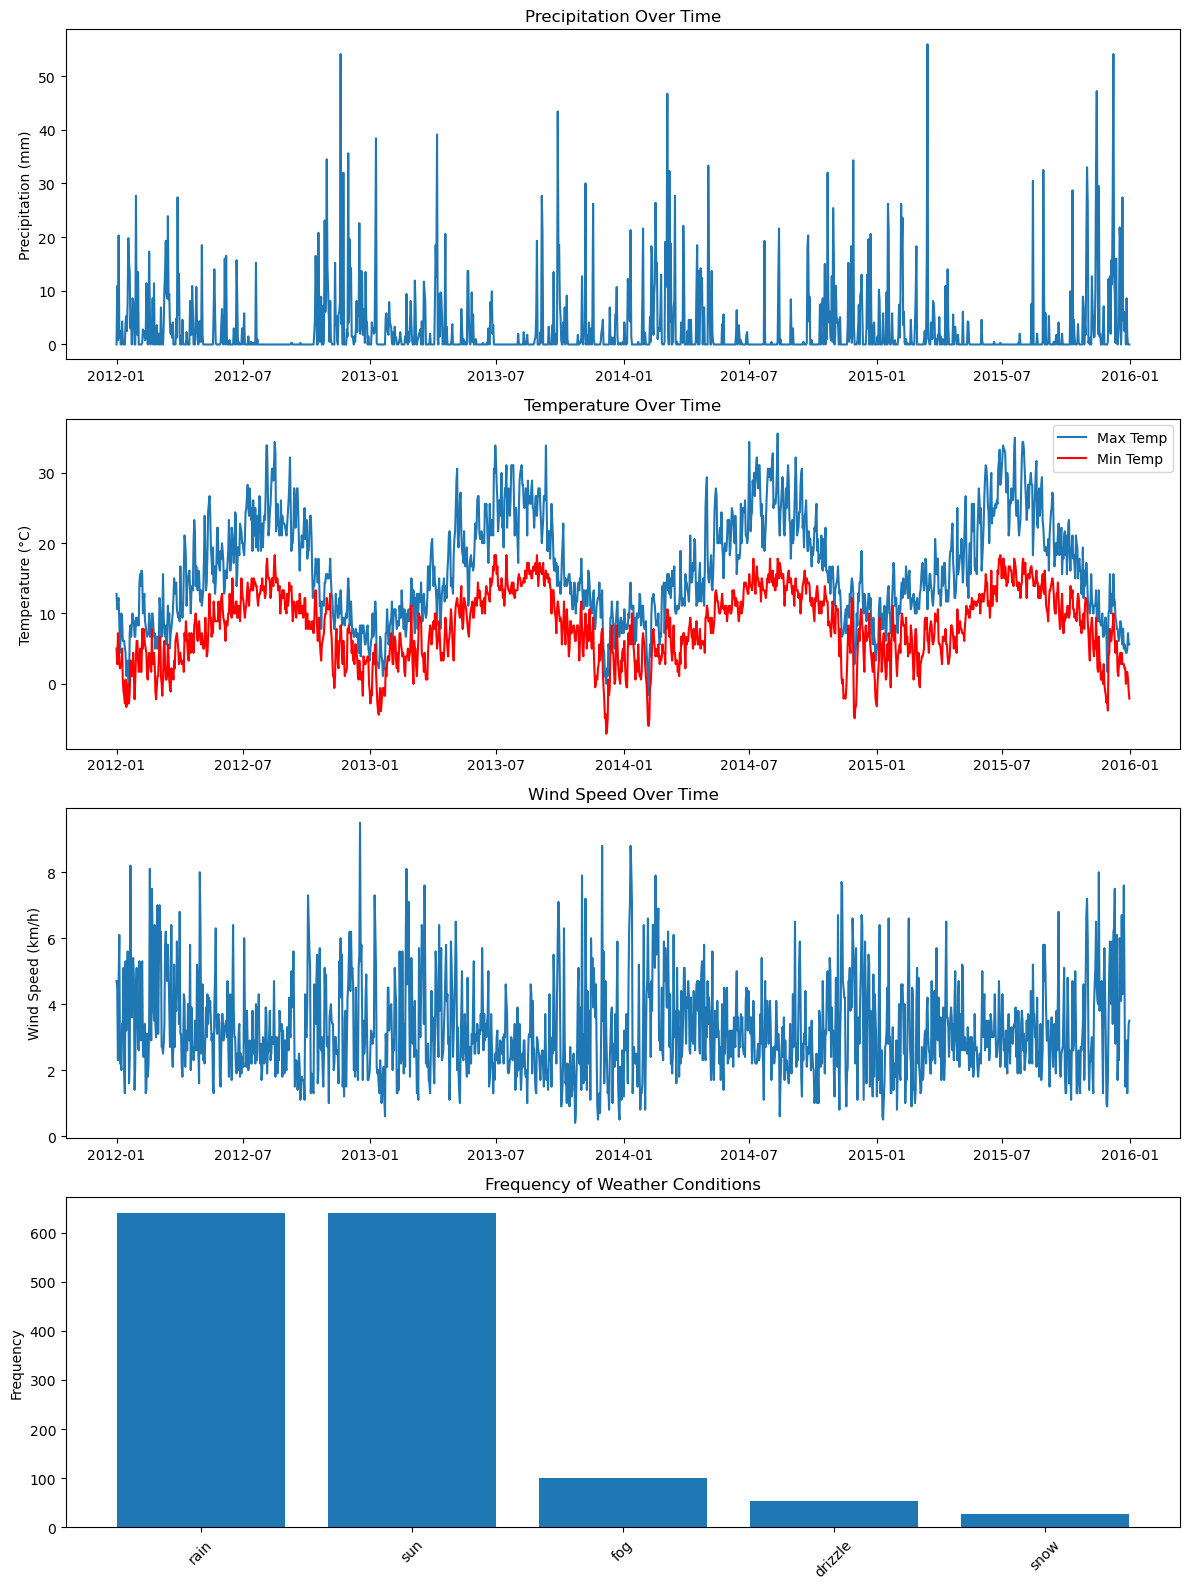

In [36]:
# Plotting time series data for precipitation, temperatures, and wind
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

# Precipitation plot
axs[0].plot(data['date'], data['precipitation'])
axs[0].set_title('Precipitation Over Time')
axs[0].set_ylabel('Precipitation (mm)')

# Temperature plot (max and min)
axs[1].plot(data['date'], data['temp_max'], label='Max Temp')
axs[1].plot(data['date'], data['temp_min'], label='Min Temp', color='red')
axs[1].set_title('Temperature Over Time')
axs[1].set_ylabel('Temperature (°C)')
axs[1].legend()

# Wind plot
axs[2].plot(data['date'], data['wind'])
axs[2].set_title('Wind Speed Over Time')
axs[2].set_ylabel('Wind Speed (km/h)')

# Weather condition frequency (Bar plot)
weather_counts = data['weather'].value_counts()
axs[3].bar(weather_counts.index, weather_counts.values)
axs[3].set_title('Frequency of Weather Conditions')
axs[3].set_ylabel('Frequency')
axs[3].set_xticklabels(weather_counts.index, rotation=45)

# Tight layout to prevent overlap
plt.tight_layout()
plt.show()


Time Series Plot for Precipitation: Helps in understanding precipitation trends over time.<br>
Time Series Plot for Temperatures (Max and Min): Provides insights into temperature fluctuations.<br>
Time Series Plot for Wind Speed: Visualizes changes in wind speed over time.<br>
Bar Plot for Weather Conditions: Shows the frequency of different weather conditions, providing a qualitative insight into the weather types.<br>


/Users/shriyansh/Documents/chrome-downloads/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shriyansh/Documents/chrome-downloads/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shriyansh/Documents/chrome-downloads/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


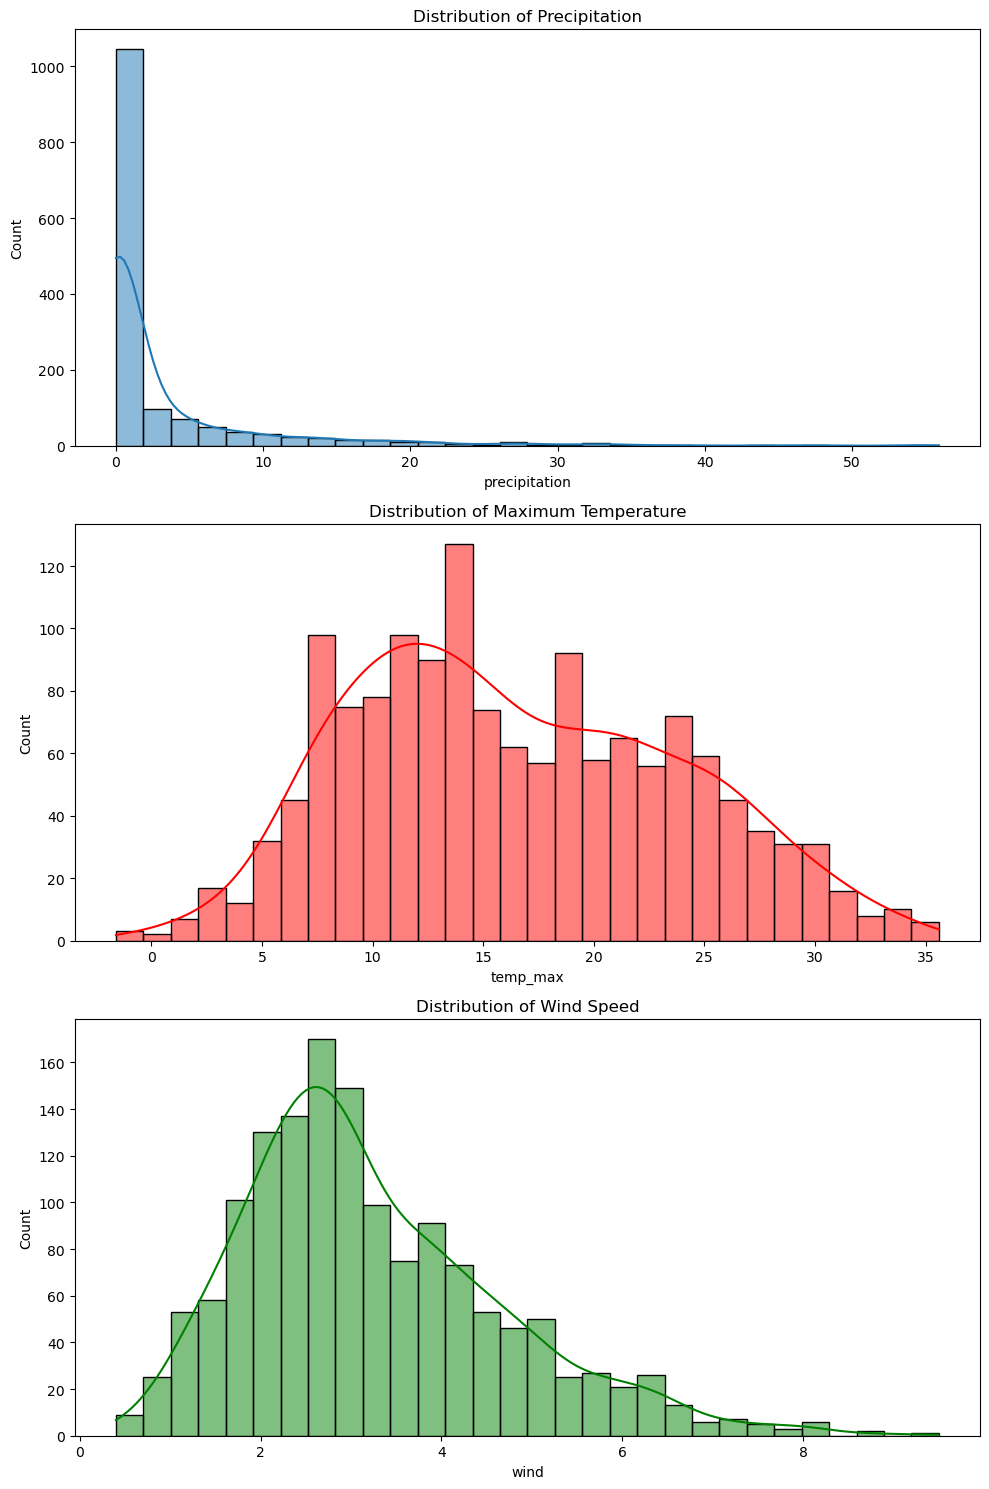

In [43]:
# Distribution of continuous variables
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
sns.histplot(data['precipitation'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Precipitation')

sns.histplot(data['temp_max'], bins=30, kde=True, color='red', ax=axs[1])
axs[1].set_title('Distribution of Maximum Temperature')

sns.histplot(data['wind'], bins=30, kde=True, color='green', ax=axs[2])
axs[2].set_title('Distribution of Wind Speed')

plt.tight_layout()
plt.show()


# Statistical Analysis

Correlation Matrix:
                precipitation  temp_max  temp_min      wind
precipitation       1.000000 -0.228555 -0.072684  0.328045
temp_max           -0.228555  1.000000  0.875687 -0.164857
temp_min           -0.072684  0.875687  1.000000 -0.074185
wind                0.328045 -0.164857 -0.074185  1.000000


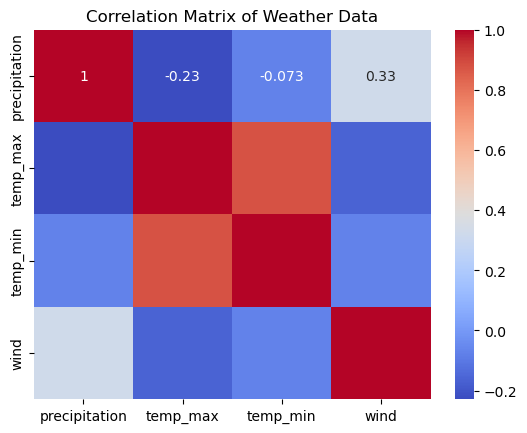

In [45]:
# Correlation matrix of numerical data
correlation_matrix = data[['precipitation', 'temp_max', 'temp_min', 'wind']].corr()
print("Correlation Matrix:\n", correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Weather Data')
plt.show()

Hypothesis Testing : Compares the mean maximum temperature on rainy days versus non-rainy days. The null hypothesis (H0) is that there is no significant difference between these means. The alternative hypothesis (H1) is that there is a difference.

In [64]:
rainy_data = data[data['weather'].str.contains('rain')]
non_rainy_data = data[~data['weather'].str.contains('rain')]

t_stat, p_value = stats.ttest_ind(rainy_data['temp_max'], non_rainy_data['temp_max'], equal_var=False)
print(f"T-test results -- t-statistic: {t_stat}, p-value: {p_value}")

T-test results -- t-statistic: -15.525706291209152, p-value: 2.9660756166950107e-50


Interpretation
The t-statistic of -15.53 is a measure of the difference between the mean maximum temperatures on rainy and non-rainy days, expressed in terms of the standard error. A negative value indicates that the mean maximum temperature on rainy days is lower than on non-rainy days.

The p-value is extremely small , far below any common significance level (e.g., 0.01, 0.05). This indicates that the observed difference in mean maximum temperatures is highly unlikely to have occurred by chance under the null hypothesis of no difference.

Conclusion
Based on the t-test results, we reject the null hypothesis that there is no difference in the mean maximum temperatures on rainy and non-rainy days. We conclude that there is a statistically significant difference, with the maximum temperature being lower on rainy days compared to non-rainy days. This conclusion is supported with a very high degree of confidence due to the extremely low p-value.

Implications
This finding can be useful for further investigations into the effects of rain on temperature variations, which could have practical implications in weather forecasting, agricultural planning, and even public health advisories related to weather changes.

If further analysis or action is required based on these results, such as examining other weather parameters or incorporating these findings into a predictive model, it can now be approached with a validated understanding of temperature differences linked to rainfall.

In [96]:
# Select the variable to forecast
temp_max = data['temp_max'].values

# Split the data into training and test sets
train_data, test_data = train_test_split(temp_max, test_size=0.2, random_state=42, shuffle=False)

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

test_stationarity(train_data)



ADF Statistic: -2.467836
p-value: 0.123498
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


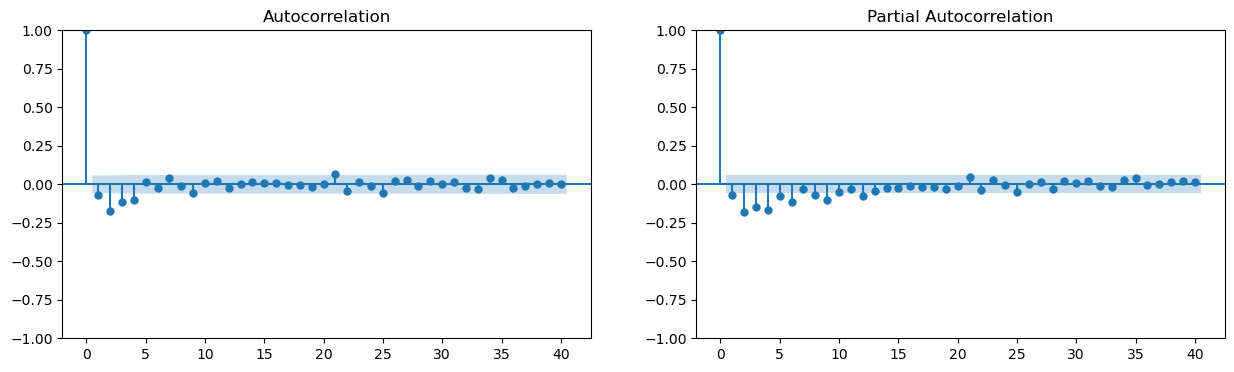

In [104]:
# Since data is likely non-stationary, difference the data
train_diff = np.diff(train_data, n=1)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(train_diff, ax=axes[0], lags=40)
plot_pacf(train_diff, ax=axes[1], lags=40, method='ywm')
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2806.794
Date:                Thu, 27 Jun 2024   AIC                           5619.588
Time:                        14:07:29   BIC                           5634.774
Sample:                             0   HQIC                          5625.316
                               - 1168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6414      0.036     18.067      0.000       0.572       0.711
ma.L1         -0.9060      0.021    -42.964      0.000      -0.947      -0.865
sigma2         7.1848      0.273     26.321      0.0

/Users/shriyansh/Documents/chrome-downloads/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


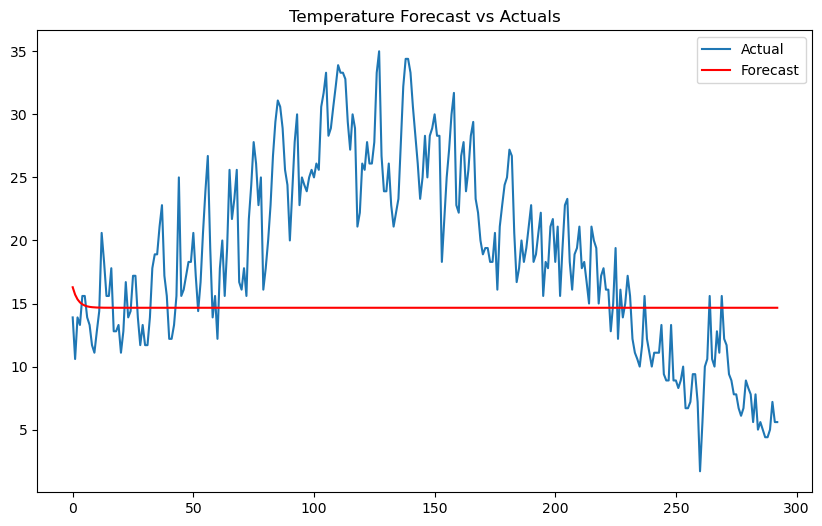

In [100]:
p = 1 
d = 1
q = 1 

# Fit the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Forecast
forecasts = model_fit.forecast(steps=len(test_data))
print(model_fit.summary())

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecasts))
print(f'Test RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(forecasts, color='red', label='Forecast')
plt.title('Temperature Forecast vs Actuals')
plt.legend()
plt.show()


# LSTM

Epoch 1/20


/Users/shriyansh/Documents/chrome-downloads/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1164/1164 - 1s - 605us/step - loss: 0.0179
Epoch 2/20
1164/1164 - 0s - 269us/step - loss: 0.0069
Epoch 3/20
1164/1164 - 0s - 269us/step - loss: 0.0065
Epoch 4/20
1164/1164 - 0s - 270us/step - loss: 0.0063
Epoch 5/20
1164/1164 - 0s - 270us/step - loss: 0.0061
Epoch 6/20
1164/1164 - 0s - 269us/step - loss: 0.0061
Epoch 7/20
1164/1164 - 0s - 269us/step - loss: 0.0059
Epoch 8/20
1164/1164 - 0s - 270us/step - loss: 0.0060
Epoch 9/20
1164/1164 - 0s - 283us/step - loss: 0.0059
Epoch 10/20
1164/1164 - 0s - 271us/step - loss: 0.0059
Epoch 11/20
1164/1164 - 0s - 271us/step - loss: 0.0058
Epoch 12/20
1164/1164 - 0s - 283us/step - loss: 0.0059
Epoch 13/20
1164/1164 - 0s - 270us/step - loss: 0.0058
Epoch 14/20
1164/1164 - 0s - 271us/step - loss: 0.0058
Epoch 15/20
1164/1164 - 0s - 270us/step - loss: 0.0059
Epoch 16/20
1164/1164 - 0s - 271us/step - loss: 0.0058
Epoch 17/20
1164/1164 - 0s - 270us/step - loss: 0.0057
Epoch 18/20
1164/1164 - 0s - 271us/step - loss: 0.0057
Epoch 19/20
1164/1164 - 0s - 2

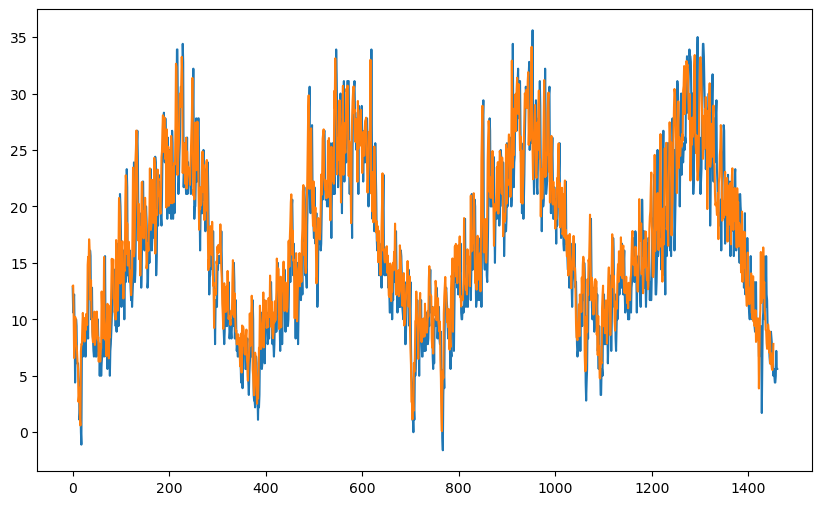

In [109]:
# Selecting 'temp_max' for forecasting
temperature = data['temp_max'].values.reshape(-1, 1)

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature)

# Split data into training and testing set
train_size = int(len(temperature_scaled) * 0.80)
test_size = len(temperature_scaled) - train_size
train, test = temperature_scaled[0:train_size,:], temperature_scaled[train_size:len(temperature_scaled),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

# Plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(temperature_scaled))
plt.plot(np.concatenate([train_predict, test_predict]))
plt.show()